In [40]:
    ### TASK-1 ###
import random
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


In [41]:
df=pd.read_csv("HAM10000_metadata.csv")

selected_class=['bkl','nvl','mel']
class_indx={'bkl':0,'nvl':1,'mel':2}
df=df[df["dx"].isin(selected_class)]
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
8834,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity
9546,HAM_0003807,ISIC_0032655,bkl,consensus,40.0,male,unknown
9630,HAM_0003807,ISIC_0033620,bkl,consensus,40.0,male,unknown
9631,HAM_0003808,ISIC_0034040,bkl,consensus,40.0,male,unknown


In [42]:
img_path=[]
labels=[]
for i in range(len(df)):
    image_name=df.iloc[i]['image_id']+".jpg"
    label_name=df.iloc[i]['dx']
    path1 = "HAM10000_images_part_1/" + image_name
    path2 = "HAM10000_images_part_2/" + image_name
    try:
        Image.open(path1)
        img_path.append(path1)
    except:
        img_path.append(path2)
    labels.append(class_indx[label_name])

In [43]:
class ISIC_dataset(Dataset):
    def __init__(self,img_path,labels,transforms=None):
        self.img_path=img_path
        self.labels=labels
        self.transforms=transforms
    def __len__(self):
        return len(self.img_path)
    def __getitem__(self, index):
        image=Image.open(self.img_path[index]).convert("RGB")
        label=self.labels[index]
        if self.transforms:
            image=self.transforms(image)
        return image,label


In [44]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
full_dataset = ISIC_dataset(
    img_path=img_path,
    labels=labels,
    transforms=train_transform
)


In [45]:
train_size=int(0.8*len(full_dataset))
val_size=len(full_dataset)-train_size
train_dataset,val_dataset=random_split(full_dataset,[train_size,val_size], generator=torch.Generator().manual_seed(42))

#shuffle
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)


In [46]:

    ###---TASK-2---###
  
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [47]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 16* 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 224 → 112
        x = self.pool(torch.relu(self.conv2(x)))  # 112 → 56
        x = self.pool(torch.relu(self.conv3(x)))  # 56 → 28

        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3 
cnn_model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)


In [49]:
num_epochs = 3

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}")


Epoch [1/3], Training Loss: 0.6632
Epoch [2/3], Training Loss: 0.5731
Epoch [3/3], Training Loss: 0.5512


In [50]:
cnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")
torch.save(cnn_model.state_dict(), "baseline_cnn_isic.pth")
print("Model saved successfully")


Validation Accuracy: 68.62%
Model saved successfully


In [51]:
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = models.resnet18(weights=True)
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)

resnet_model = resnet_model.to(device)

resnet_model.fc


c:\Users\varsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=3, bias=True)

In [52]:
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.fc.parameters():
    param.requires_grad = True


In [53]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)


In [54]:
num_epochs = 3

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}")


Epoch [1/3], Training Loss: 0.6999
Epoch [2/3], Training Loss: 0.5929
Epoch [3/3], Training Loss: 0.5389


In [55]:
resnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"ResNet Validation Accuracy: {accuracy:.2f}%")


ResNet Validation Accuracy: 73.14%


In [56]:
###----TASK_4---###


import torch
import numpy as np

def get_predictions(model, dataloader):
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [57]:
# CNN
cnn_labels, cnn_preds, cnn_probs = get_predictions(cnn_model, val_loader)

# ResNet
resnet_labels, resnet_preds, resnet_probs = get_predictions(resnet_model, val_loader)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(name, y_true, y_pred):
    print(f"\n{name} Metrics")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score :", f1_score(y_true, y_pred, average='weighted'))
print_metrics("CNN", cnn_labels, cnn_preds)
print_metrics("ResNet", resnet_labels, resnet_preds)




CNN Metrics
Accuracy : 0.690744920993228
Precision: 0.7153377312397311
Recall   : 0.690744920993228
F1-score : 0.6841424769703651

ResNet Metrics
Accuracy : 0.7291196388261851
Precision: 0.7292101311236152
Recall   : 0.7291196388261851
F1-score : 0.7291500239213567


In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred,labels=[0,1,2])

    plt.figure(figsize=(6, 6))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()

    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [59]:
print("Unique true labels:", np.unique(cnn_labels))
print("Unique predicted labels:", np.unique(cnn_preds))

Unique true labels: [0 2]
Unique predicted labels: [0 2]


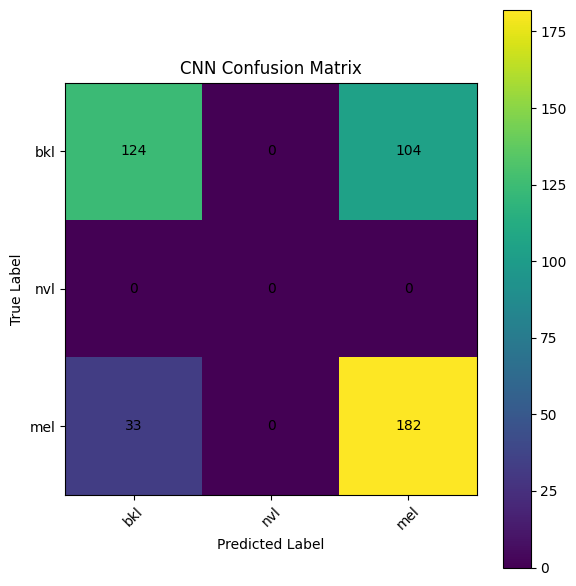

In [60]:
class_names = [ "bkl", "nvl", "mel"]

plot_confusion_matrix(
    cnn_labels,
    cnn_preds,
    class_names,
    "CNN Confusion Matrix"
)


In [61]:
from sklearn.metrics import roc_auc_score

binary_auc = roc_auc_score(
    resnet_labels,
    resnet_probs[:, 2]   # probability of class 2
)

print("Binary ROC-AUC:", binary_auc)


Binary ROC-AUC: 0.7930028559771521


c:\Users\varsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


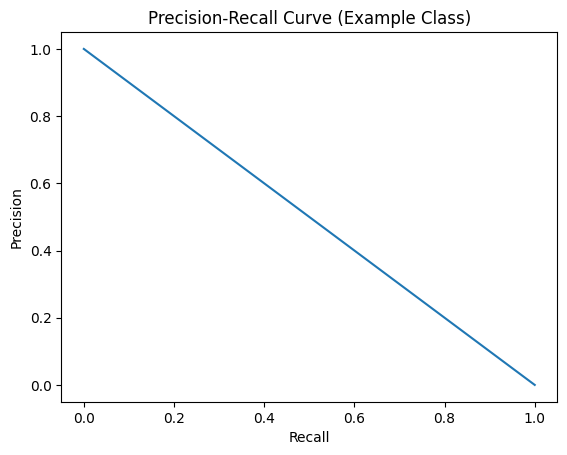

In [62]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(
    (resnet_labels == 1).astype(int),   # pick one class
    resnet_probs[:, 1]
)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Example Class)")
plt.show()
